In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm


In [ ]:
pip install split-folders

# Preparing data

In [ ]:
import os
import splitfolders 

current_dir = os.path.abspath(os.getcwd())

os.mkdir(current_dir + "\\SliptDataSet")

dir_all_images = current_dir + "\\lung_colon_image_set"

input_folder_colon = dir_all_images + "\\colon_image_sets"
input_folder_lung = dir_all_images + "\\lung_image_sets"

output_colon = current_dir + "\\SliptDataSet"
output_lung = current_dir + "\\SliptDataSet" 

splitfolders.ratio(input_folder_colon, output=output_colon, seed=42, ratio=(0.4, 0.0, 0.6))
splitfolders.ratio(input_folder_lung, output=output_lung, seed=42, ratio=(0.4, 0.0, 0.6))

.//SliptDataSet//train\colon_aca
colonca1.jpeg
[[[234 235 255]
  [235 236 255]
  [234 229 255]
  ...
  [228 178 220]
  [226 176 218]
  [218 168 210]]

 [[234 233 253]
  [236 234 255]
  [235 230 255]
  ...
  [225 172 215]
  [223 170 213]
  [215 162 205]]

 [[235 230 251]
  [238 232 255]
  [239 229 255]
  ...
  [223 169 212]
  [219 165 208]
  [211 157 200]]

 ...

 [[253 209 250]
  [255 211 252]
  [254 211 254]
  ...
  [235 197 249]
  [234 196 248]
  [235 197 249]]

 [[253 207 249]
  [254 210 251]
  [253 210 253]
  ...
  [239 200 255]
  [236 197 252]
  [233 194 249]]

 [[249 203 245]
  [250 206 247]
  [253 208 251]
  ...
  [243 204 255]
  [239 200 255]
  [235 196 251]]]


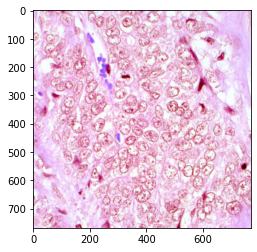

In [2]:
dir_train = ".//SliptDataSet//train"
dir_test = ".//SliptDataSet//test"

CATEGORIES = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

for category in CATEGORIES:  
    path = os.path.join(dir_train,category) 
    for img in os.listdir(path): 
        print(path)
        print(img)
        if(os.path.isfile(os.path.join(path,img))):
            img_array = cv2.imread(os.path.join(path,img)) 
            print(img_array)
        else:
            print ("The file " + os.path.join(path,img) + " does not exist.")
        plt.imshow(img_array)  
        plt.show()  

        break  
    break  

In [3]:
print(img_array.shape)

(768, 768, 3)


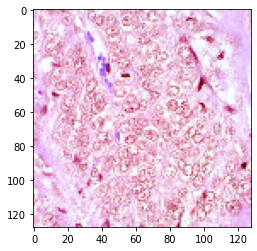

In [4]:
IMG_SIZE = 128

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [6]:
def create_data(dir):
    data = []
    for category in CATEGORIES:

        path = os.path.join(dir,category) 
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                data.append([new_array, class_num])  
            except Exception as e:  
                pass
    return data

training_data = create_data(dir_train)
testing_data = create_data(dir_test)

print("Train size: " + len(training_data))
print("Testsize: " + len(testing_data))

100%|██████████| 1553/1553 [00:08<00:00, 182.64it/s]

9035


In [7]:
import random

random.shuffle(training_data)
random.shuffle(testing_data)

In [8]:
def getFeatureLabel(data, IMG_SIZE = 128):
    x = []
    y = []

    for features,label in data:
        x.append(features)
        y.append(label)

    print(x[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

    x = np.array(x).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    return x,y

In [9]:
x_train, y_train = getFeatureLabel(training_data)
x_test, y_test = getFeatureLabel(testing_data)

[[[[250 211 203]
   [252 213 205]
   [250 211 203]
   ...
   [251 211 206]
   [252 209 206]
   [252 203 205]]

  [[251 212 204]
   [254 215 207]
   [250 211 203]
   ...
   [251 214 206]
   [251 211 206]
   [250 207 204]]

  [[251 212 204]
   [254 215 207]
   [250 211 203]
   ...
   [249 216 205]
   [249 212 204]
   [250 210 205]]

  ...

  [[248 149 194]
   [251 154 194]
   [253 157 194]
   ...
   [253 212 210]
   [248 207 205]
   [252 211 209]]

  [[248 150 194]
   [251 154 194]
   [253 157 194]
   ...
   [249 208 206]
   [248 207 205]
   [252 211 209]]

  [[251 153 197]
   [249 152 192]
   [253 157 194]
   ...
   [247 206 204]
   [251 210 208]
   [251 210 208]]]]
[[[[202 155 201]
   [206 154 202]
   [208 152 203]
   ...
   [205 171 209]
   [213 177 205]
   [203 186 205]]

  [[202 148 201]
   [209 151 206]
   [200 139 198]
   ...
   [167  59 179]
   [167  81 198]
   [175 111 187]]

  [[202 142 201]
   [193 129 191]
   [192 124 186]
   ...
   [177  63 203]
   [140  43 217]
   [157  52 

In [10]:
x_train.shape

(9035, 128, 128, 3)

In [24]:
x_test.shape

(13553, 128, 128, 3)

In [17]:
x_train_flat = x_train.reshape((9035, 128*128*3))
x_test_flat = x_test.reshape((13553, 128*128*3))

In [18]:
x_train_flat_normalized = x_train_flat/255.0
x_test_flat_normalized = x_test_flat/255.0

In [40]:
laplacian_kernel = np.array([[0, 1, 0], 
                      [1, -4, 1], 
                      [0, 1, 0]])

In [62]:
x_train.shape

(9035, 128, 128, 3)

In [69]:
convolution_train = []
convolution_test = [] 
for image in x_train:
    x = np.array(cv2.filter2D(image, -1, laplacian_kernel))
    convolution_train.append(x)

for image in x_test:
    x = cv2.filter2D(image, -1, laplacian_kernel)
    convolution_test.append(x)

In [70]:
np.array(convolution_test).shape

(13553, 128, 128, 3)

In [72]:
x_train_flat_conv = np.array(convolution_train).reshape((9035, 128*128*3))
x_test_flat_conv = np.array(convolution_test).reshape((13553, 128*128*3))

In [73]:
x_train_flat_normalized_conv = x_train_flat_conv/255.0
x_test_flat_normalized_conv = x_test_flat_conv/255.0

# KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)


In [26]:
knn.fit(x_train_flat_normalized, y_train)
result = knn.predict(np.array(x_test_flat_normalized))

In [27]:
result

array([2, 3, 0, ..., 4, 0, 4])

In [28]:
from sklearn import metrics

print(metrics.classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.38      0.54      0.44      3000
           1       1.00      0.00      0.00      3000
           2       0.04      0.02      0.03      3000
           3       1.00      0.49      0.66      3000
           4       0.24      1.00      0.39      1553

    accuracy                           0.35     13553
   macro avg       0.53      0.41      0.30     13553
weighted avg       0.56      0.35      0.29     13553



# KNN (With Convolution)

In [74]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)

In [79]:
knn.fit(x_train_flat_conv , y_train)
result = knn.predict(x_test_flat_conv )

In [80]:
print(metrics.classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3000
           1       0.00      0.00      0.00      3000
           2       0.34      0.16      0.22      3000
           3       0.59      0.22      0.32      3000
           4       0.11      0.78      0.19      1553

    accuracy                           0.17     13553
   macro avg       0.21      0.23      0.15     13553
weighted avg       0.22      0.17      0.14     13553



C:\Users\mathe\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mathe\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mathe\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=42)
tree_clf.fit(x_train_flat, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [38]:
y_pred = tree_clf.predict(x_test_flat)

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

result = classification_report(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(acc)
print(result)

0.6235519811111931
              precision    recall  f1-score   support

           0       0.47      0.22      0.30      3000
           1       0.55      0.78      0.64      3000
           2       0.55      0.91      0.68      3000
           3       0.98      0.89      0.93      3000
           4       0.30      0.02      0.04      1553

    accuracy                           0.62     13553
   macro avg       0.57      0.57      0.52     13553
weighted avg       0.60      0.62      0.57     13553



# CNN

In [11]:
from keras.utils.np_utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_train_encoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [12]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = keras.Sequential()

model.add(Rescaling(scale=1.0/255))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [13]:
model.build((None, 128, 128, 3) )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

In [1]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        filepath="model1.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    x_train,
    y_train_encoded,
    epochs=5,
    callbacks=callbacks)

NameError: name 'model' is not defined

In [16]:
test_loss, test_acc = model.evaluate(x_test, np.array(y_test_encoded))
print(f"Test accuracy: {test_acc:.3f}")

424/424 [==============================] - 5s 11ms/step - loss: 0.2469 - accuracy: 0.9257
Test accuracy: 0.926
